# Mask-RCNN Model Inference in Amazon SageMaker

This notebook is a step-by-step tutorial on [Mask R-CNN](https://arxiv.org/abs/1703.06870) model inference using [Amazon SageMaker model deployment hosting service](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

To get started, we initialize an Amazon execution role and initialize a `boto3` session to find our AWS region name.

In [23]:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role() # provide a pre-existing role ARN as an alternative to creating a new role
print(f'SageMaker Execution Role:{role}')

session = boto3.session.Session()
aws_region = session.region_name
print(f'AWS region:{aws_region}')

SageMaker Execution Role:arn:aws:iam::807253771232:role/sagemaker-ExecutionRole-6JD6KWXPOLHQ
AWS region:us-west-2


## Build and Push Amazon SageMaker Serving Container Images

For this step, the [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) attached to this notebook instance needs full access to [Amazon ECR service](https://aws.amazon.com/ecr/). If you created this notebook instance using the ```./stack-sm.sh``` script in this repository, the IAM Role attached to this notebook instance is already setup with full access to Amazon ECR service. 

Below, we have a choice of two different models for doing inference:

1. [TensorPack Faster-RCNN/Mask-RCNN](https://github.com/tensorpack/tensorpack/tree/master/examples/FasterRCNN)

2. [AWS Samples Mask R-CNN](https://github.com/aws-samples/mask-rcnn-tensorflow)

It is recommended that you build and push both Amazon SageMaker <b>serving</b> container images below and use one of the two container images for serving the model from an Amazon SageMaker Endpoint.


### Build and Push TensorPack Faster-RCNN/Mask-RCNN Serving Container Image

Use ```./container-serving/build_tools/build_and_push.sh``` script to build and push the [TensorPack Faster-RCNN/Mask-RCNN](https://github.com/tensorpack/tensorpack/tree/master/examples/FasterRCNN) <b>serving</b> container image to Amazon ECR. 

In [ ]:
!cat ./container-serving/build_tools/build_and_push.sh

Using your *AWS region* as argument, run the cell below.

In [ ]:
%%time
! ./container-serving/build_tools/build_and_push.sh {aws_region}

Set ```tensorpack_image``` below to Amazon ECR URI of the <b>serving</b> image you pushed above.

In [24]:
tensorpack_image = '807253771232.dkr.ecr.us-west-2.amazonaws.com/mask-rcnn-tensorpack-serving-sagemaker:tf1.15-tpdb541e8'# mask-rcnn-tensorpack-serving-sagemaker ECR URI

### Build and Push AWS Samples Mask R-CNN Serving Container Image
Use ```./container-serving-optimized/build_tools/build_and_push.sh``` script to build and push the [AWS Samples Mask R-CNN](https://github.com/aws-samples/mask-rcnn-tensorflow) <b>serving</b> container image to Amazon ECR.

In [ ]:
!cat ./container-serving-optimized/build_tools/build_and_push.sh

Using your *AWS region* as argument, run the cell below.

In [ ]:
%%time
! ./container-serving-optimized/build_tools/build_and_push.sh {aws_region}

 Set ```aws_samples_image``` below to Amazon ECR URI of the <b>serving</b> image you pushed above.

In [ ]:
aws_samples_image = # mask-rcnn-tensorflow-serving-sagemaker ECR URI

## Select Serving Container Image
Above, we built and pushed [TensorPack Faster-RCNN/Mask-RCNN](https://github.com/tensorpack/tensorpack/tree/master/examples/FasterRCNN) and [AWS Samples Mask R-CNN](https://github.com/aws-samples/mask-rcnn-tensorflow) serving container images to Amazon ECR. Now we are ready to deploy our trained model to an Amazon SageMaker Endpoint using one of the two container images.

Next, we set ```serving_image``` to either the `tensorpack_image` or the `aws_samples_image` variable you defined above, making sure that the serving container image we set below matches our trained model.

In [25]:
serving_image = tensorpack_image # set to tensorpack_image or aws_samples_image  variable (no string quotes)
print(f'serving image: {serving_image}')

serving image: 807253771232.dkr.ecr.us-west-2.amazonaws.com/mask-rcnn-tensorpack-serving-sagemaker:tf1.15-tpdb541e8


## Create Amazon SageMaker Session 
Next, we create a SageMaker session.

In [27]:
sagemaker_session = sagemaker.session.Session(boto_session=session)

## Define Amazon SageMaker Model
Next, we define an Amazon SageMaker Model that defines the deployed model we will serve from an Amazon SageMaker Endpoint. 

In [26]:
model_name= 'mask-rcnn-model-1'# Name of the model

This model assumes you are using ResNet-50 pre-trained model weights for the ResNet backbone. If this is not true, please adjust  `PRETRAINED_MODEL` value below. Please ensure that the `s3_model_url` of your trained model used below is consistent with the container `serving_image` you set above.

In [28]:
s3_model_url = 's3://aws-ajayvohra-ml-labs/mask-rcnn/sagemaker/output/mask-rcnn-efs-1613672316/output/model.tar.gz'# Trained Model Amazon S3 URI in the format s3://<your path>/model.tar.gz
serving_container_def = {
    'Image': serving_image,
    'ModelDataUrl': s3_model_url,
    'Mode': 'SingleModel',
    'Environment': { 'SM_MODEL_DIR' : '/opt/ml/model',
                     'RESNET_ARCH': 'resnet50' # 'resnet50' or 'resnet101'
                   }
}

create_model_response = sagemaker_session.create_model(name=model_name, 
                                                       role=role, 
                                                       container_defs=serving_container_def)

print(create_model_response)

mask-rcnn-model-1


 Next, we set the name of the Amaozn SageMaker hosted service endpoint configuration.

In [29]:
endpoint_config_name=f'{model_name}-endpoint-config'
print(endpoint_config_name)

mask-rcnn-model-1-endpoint-config


Next, we create the Amazon SageMaker hosted service endpoint configuration that uses one instance of `ml.p3.2xlarge` to serve the model.

In [30]:
epc = sagemaker_session.create_endpoint_config(
    name=endpoint_config_name, 
    model_name=model_name, 
    initial_instance_count=1, 
    instance_type='ml.g4dn.xlarge')
print(epc)

mask-rcnn-model-1-endpoint-config


Next we specify the Amazon SageMaker endpoint name for the endpoint used to serve the model.

In [31]:
endpoint_name=f'{model_name}-endpoint'
print(endpoint_name)

mask-rcnn-model-1-endpoint


Next, we create the Amazon SageMaker endpoint using the endpoint configuration we created above.

In [32]:
ep=sagemaker_session.create_endpoint(endpoint_name=endpoint_name, config_name=endpoint_config_name, wait=True)
print(ep)

-----------------!mask-rcnn-model-1-endpoint


Now that the Amazon SageMaker endpoint is in service, we will use the endpoint to do inference for test images. 

Next, we download [COCO 2017 Test images](http://cocodataset.org/#download).

In [ ]:
!wget -O ./test2017.zip http://images.cocodataset.org/zips/test2017.zip

--2021-02-24 00:05:42--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.47.44
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.47.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘./test2017.zip’

./test2017.zip      100%[===================>]   6.19G  20.8MB/s    in 5m 4s   

2021-02-24 00:10:47 (20.9 MB/s) - ‘./test2017.zip’ saved [6646970404/6646970404]



We extract the downloaded COCO 2017 Test images to the home directory.

In [34]:
!unzip -q ./test2017.zip
!rm  ./test2017.zip

Below, we will use the downloaded COCO 2017 Test images to test our deployed Mask R-CNN model. However, in order to visualize the detection results, we need to define some helper functions.

## Visualization Helper Functions
Next, we define a helper function to convert COCO Run Length Encoding (RLE) to a binary image mask. 

The RLE encoding is a dictionary with two keys `counts` and `size`. The `counts` value is a list of counts of run lengths of alternating 0s and 1s for an image binary mask for a specific instance segmentation, with the image is scanned row-wise. The `counts` list  starts with a count of 0s. If the binary mask value at `(0,0)` pixel is 1, then the `counts` list starts with a `0`. The `size` value is a list containing image height and width.

In [35]:
import numpy as np

def rle_to_binary_mask(rle, img_shape):
    value = 0
    mask_array = []
    for count in rle:
        mask_array.extend([int(value)]*count)
        value = (value + 1) % 2
    
    assert len(mask_array) == img_shape[0]*img_shape[1]
    b_mask = np.array(mask_array, dtype=np.uint8).reshape(img_shape)
    
    return b_mask

Next, we define a helper function for generating random colors for visualizing detection results.

In [36]:
import colorsys
import random

def random_colors(N, bright=False):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

Next, we define a helper function to apply an image binary mask for an instance segmentation to the image. Each image binary mask is of the size of the image.

In [37]:
def apply_mask(image, mask, color, alpha=0.5):
    a_mask = np.stack([mask]*3, axis=2).astype(np.int8)
    for c in range(3):
        image[:, :, c] = np.where(mask == 1, image[:, :, c] *(1 - alpha) + alpha * color[c]*255,image[:, :, c])
    return image

Next, we define a helper function to show the applied detection results.

In [38]:
import matplotlib.pyplot as plt
from matplotlib import patches

def show_detection_results(img=None,
                            annotations=None):
    """
    img: image numpy array
    annotations: annotations array for image where each annotation is in COCO format
    """
    num_annotations = len(annotations)
    colors = random_colors(num_annotations)
    
    fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
    
    for i, a in enumerate(annotations):
        segm = a['segmentation']
        
        img_shape = tuple(segm['size'])
        rle = segm['counts']
        binary_image_mask = rle_to_binary_mask(rle, img_shape)
        
        bbox = a['bbox']
        category_id = a['category_id']
        category_name = a['category_name']
    
        # select color from random colors
        color = colors[i]

        # Show bounding box
        bbox_x, bbox_y, bbox_w, bbox_h = bbox

        box_patch = patches.Rectangle((bbox_x, bbox_y), bbox_w, bbox_h, 
                        linewidth=1,
                        alpha=0.7, linestyle="dashed",
                        edgecolor=color, facecolor='none')
        ax.add_patch(box_patch)
        label = f'{category_name}:{category_id}'
        ax.text(bbox_x, bbox_y + 8, label,
                color='w', size=11, backgroundcolor="none")

        # Show mask
        img = apply_mask(img, binary_image_mask.astype(np.bool), color)

    
    ax.imshow(img.astype(int))
    plt.show()

## Visualize Detection Results
Next, we select a random image from COCO 2017 Test image dataset. After you are done visualizing the detection results for this image, you can come back to the cell below and select your next random image to test.

In [45]:
import os
import random

test2017_dir=os.path.join(".", "test2017")
img_id=random.choice(os.listdir(test2017_dir))
img_local_path = os.path.join(test2017_dir,img_id)
print(img_local_path)

./test2017/000000547729.jpg


Next, we read the image and convert it from BGR color to RGB color format.

In [46]:
import cv2

img=cv2.imread(img_local_path, cv2.IMREAD_COLOR)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(480, 640, 3)


Next, we show the image that we randomly selected.

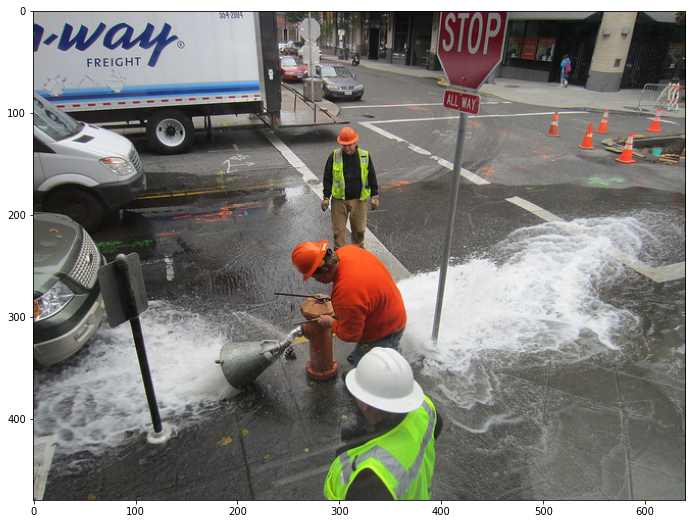

In [47]:
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(img.astype(int))
plt.show()

Next, we invoke the Amazon SageMaker Endpoint to detect objects in the test image that we randomly selected.

This REST API endpoint only accepts HTTP POST requests with `ContentType` set to `application/json`. The content of the POST request must conform to following JSON schema:

`{ 
    "img_id": "YourImageId", 
    "img_data": "Base64 encoded image file content, encoded as utf-8 string" 
 }`

The response of the POST request conforms to following JSON schema:

`{ 
    "annotations": [ 
                    {
                        "bbox": [X, Y, width, height], 
                        "category_id": "class id", 
                        "category_name": "class name", 
                        "segmentation": { "counts": [ run-length-encoding, ], "size": [height, width]} 
                     },
                   ]
 }`

In [48]:
import boto3 
import base64
import json

client = boto3.client('sagemaker-runtime')

with open(img_local_path, "rb") as image_file:
    img_data = base64.b64encode(image_file.read())
    data = {"img_id": img_id}
    data["img_data"] = img_data.decode('utf-8')
    body=json.dumps(data).encode('utf-8')
    
response = client.invoke_endpoint(EndpointName=endpoint_name,
                                  ContentType="application/json",
                                  Accept="application/json",
                                  Body=body)
body=response['Body'].read()
msg=body.decode('utf-8')
data=json.loads(msg)
assert data is not None

The response from the endpoint includes annotations for the detected objects in COCO annotations format. 

Next, we aplly all the detection results to the image. 

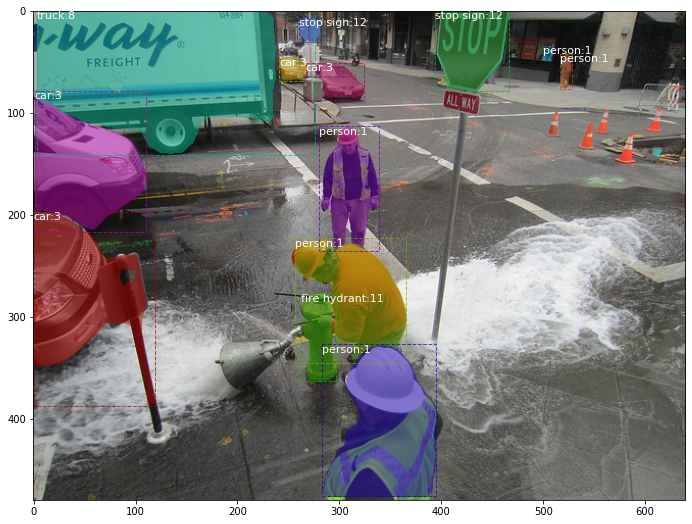

In [49]:
annotations = data['annotations']
show_detection_results(img, annotations)

## Delete SageMaker Endpoint, Endpoint Config and Model
If you are done testing, delete the deployed Amazon SageMaker endpoint, endpoint config, and the model below. The trained model in S3. bucket is not deleted. If you are not done testing, go back to the section <b>Visualize Detection Results</b> and select another test image.

In [50]:
sagemaker_session.delete_endpoint(endpoint_name=endpoint_name)
sagemaker_session.delete_endpoint_config(endpoint_config_name=endpoint_config_name)
sagemaker_session.delete_model(model_name=model_name)